# Introduction

This project aims to develop methods for patient-specific prediction of in-hospital mortality using Machine Learning techniques, in addition to analyzing patients' obsevartions to infer the relationship between obsevartions and the in-hospital death (e.g. average Platelets levels and death/survival relationship). The data consist of records from 8000 ICU stays. All patients were adults who were admitted for a wide variety of reasons to cardiac, medical, surgical, and trauma ICUs. ICU stays of less than 48 hours have been excluded.

Four thousand records comprise training set A, and the remaining records form test set B. Outcome (label column) is provided for the training set records, and withheld for the test set records.

Each observation has an associated time-stamp indicating the elapsed time of the observation since ICU admission in each case, in hours and minutes. Thus, for example, a time stamp of 35:19 means that the associated observation was made 35 hours and 19 minutes after the patient was admitted to the ICU. Moreover, Each record is stored as a comma-separated value (CSV) text file.

The ICU patient's features are illustrated as follows:
- Age (years)

- Blood urea nitrogen (mg/dL) (BUN)

- Serum creatinine (mg/dL)

- Glasgow Coma Score (GCS) 

- Serum glucose (mg/dL) 

- Heart rate (bpm)

- Serum bicarbonate (mmol/L) 

- Hematocrit (%)

- Hehight (m)

- Serum potassium (mEq/L) (K)

- Serum magnesium (mmol/L) (Mg)

- Invasive systolic arterial blood pressure (mmHg) (SysABP) 

- Non-invasive diastolic arterial blood pressure (mmHg) (NIDiasABP)

- Non-invasive mean arterial blood pressure (mmHg) (NIMAP)

- Serum sodium (mEq/L) (Na)

- Platelets (cells/nL)

- Temperature (Celisius)

- Urine output (mL)

- White blood cell count (cells/nL)

- Weight (Kg)

- Invasive diastolic arterial blood pressure (mmHg) (DiasABP)

- Fractional inspired O2 (0-1) (FiO2)

- Invasive mean arterial blood pressure (mmHg) (MAP)

- Partial pressure of arterial CO2 (mmHg) (PaCO2)

- Partial pressure of arterial O2 (mmHg) (PaO2)

- Arterial pH (0-14 Scale)

The outcome (label) that we will investigate in our analysis is the in-hospital mortality: 
- Survived (recovered and ended hospitalization): 0  
- In-hospital death: 1


For more information about the dataset, please refer to the link: https://physionet.org/content/challenge-2012/1.0.0/


In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from cf_matrix import make_confusion_matrix
from imblearn.over_sampling import ADASYN
import xgboost as xgb

# Data Extraction and Transformation

In [2]:
df = pd.DataFrame()
for file in tqdm(range(132539 , 147736)):
    try: 
        read = pd.read_csv(f'set-a/{file}.txt').drop(columns='Time')
        read_pivot = read.pivot_table(values='Value' ,columns='Parameter', aggfunc='mean')
        df = pd.concat([df,read_pivot])
    except:
        pass
# Create the dataframe from the set-A (training data) CSV text files. Each file represents a patient's data (one record).
# The file contains data with time stamp. for example, measuring the glucose levels time and value.
# As many measurments were done for the same feature (e.g. measuring glucose levels many times), we will take the average readings for each feature for the patient.   

100%|███████████████████████████████████████████████████████████████████████████| 15197/15197 [00:47<00:00, 318.92it/s]


In [3]:
df['RecordID'] = df['RecordID'].astype('int')
# RecordID should be integer for consistency.
df.head()

,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,Height,...,pH,ALP,ALT,AST,Albumin,Bilirubin,Lactate,Cholesterol,TroponinI,TroponinT
Value,54.0,10.500000,0.750000,14.923077,0.0,160.000000,27.000000,32.500000,70.810811,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Value,76.0,18.333333,1.100000,13.333333,1.0,125.500000,22.333333,28.655556,80.794118,175.3,...,7.395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Value,44.0,4.666667,0.333333,5.923077,0.0,134.333333,25.000000,28.460000,83.759259,-1.0,...,7.495,116.0,83.0,199.5,2.5,2.9,1.366667,NaN,NaN,NaN
Value,68.0,17.666667,0.766667,14.944444,1.0,117.333333,27.666667,37.442857,70.983333,180.3,...,NaN,105.0,12.0,15.0,4.4,0.2,NaN,NaN,NaN,NaN
Value,88.0,35.000000,1.000000,15.000000,0.0,102.500000,19.000000,29.550000,74.958333,-1.0,...,NaN,NaN,NaN,NaN,3.3,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5999 entries, Value to Value
Data columns (total 42 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          5999 non-null   float64
 1   BUN          5904 non-null   float64
 2   Creatinine   5904 non-null   float64
 3   GCS          5898 non-null   float64
 4   Gender       5999 non-null   float64
 5   Glucose      5839 non-null   float64
 6   HCO3         5891 non-null   float64
 7   HCT          5903 non-null   float64
 8   HR           5899 non-null   float64
 9   Height       5999 non-null   float64
 10  ICUType      5999 non-null   float64
 11  K            5864 non-null   float64
 12  Mg           5855 non-null   float64
 13  NIDiasABP    5240 non-null   float64
 14  NIMAP        5238 non-null   float64
 15  NISysABP     5256 non-null   float64
 16  Na           5892 non-null   float64
 17  Platelets    5897 non-null   float64
 18  RecordID     5999 non-null   int32  
 19  RespRa

In [5]:
target = pd.read_csv('Outcomes-a.txt')
target.head()

,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,6,1,5,-1,0
1,132540,16,8,8,-1,0
2,132541,21,11,19,-1,0
3,132543,7,1,9,575,0
4,132545,17,2,4,918,0


In [6]:
df = pd.merge(df,target[['RecordID','In-hospital_death']], on='RecordID')
df = df.set_index('RecordID') 
# merge the patients data with the target labrl to perform the analysis. Also set the RecordID as index for the dataset.

In [7]:
df.head()

,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,Height,...,ALP,ALT,AST,Albumin,Bilirubin,Lactate,Cholesterol,TroponinI,TroponinT,In-hospital_death
RecordID,,,,,,,,,,,,,,,,,,,,,
132539,54.0,10.500000,0.750000,14.923077,0.0,160.000000,27.000000,32.500000,70.810811,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
132540,76.0,18.333333,1.100000,13.333333,1.0,125.500000,22.333333,28.655556,80.794118,175.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
132541,44.0,4.666667,0.333333,5.923077,0.0,134.333333,25.000000,28.460000,83.759259,-1.0,...,116.0,83.0,199.5,2.5,2.9,1.366667,NaN,NaN,NaN,0
132543,68.0,17.666667,0.766667,14.944444,1.0,117.333333,27.666667,37.442857,70.983333,180.3,...,105.0,12.0,15.0,4.4,0.2,NaN,NaN,NaN,NaN,0
132545,88.0,35.000000,1.000000,15.000000,0.0,102.500000,19.000000,29.550000,74.958333,-1.0,...,NaN,NaN,NaN,3.3,NaN,NaN,NaN,NaN,NaN,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 132539 to 142673
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                4000 non-null   float64
 1   BUN                3936 non-null   float64
 2   Creatinine         3936 non-null   float64
 3   GCS                3936 non-null   float64
 4   Gender             4000 non-null   float64
 5   Glucose            3887 non-null   float64
 6   HCO3               3924 non-null   float64
 7   HCT                3936 non-null   float64
 8   HR                 3937 non-null   float64
 9   Height             4000 non-null   float64
 10  ICUType            4000 non-null   float64
 11  K                  3904 non-null   float64
 12  Mg                 3897 non-null   float64
 13  NIDiasABP          3483 non-null   float64
 14  NIMAP              3481 non-null   float64
 15  NISysABP           3493 non-null   float64
 16  Na               

In [9]:
 df = df.dropna(thresh=df.shape[0]*0.6,how='all',axis=1)
#Keep columns with less than 40% Null values

In [10]:
df.loc[df.pH>14, 'pH'] =  np.nan
# Nulling the out of real range pH values 

In [11]:
df['MechVent'].fillna(0,inplace=True)
# If the patient needed mechanical ventilation respiration it will be 1, else Nan (filled with 0 instead to make analysis consistant)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 132539 to 142673
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                4000 non-null   float64
 1   BUN                3936 non-null   float64
 2   Creatinine         3936 non-null   float64
 3   GCS                3936 non-null   float64
 4   Gender             4000 non-null   float64
 5   Glucose            3887 non-null   float64
 6   HCO3               3924 non-null   float64
 7   HCT                3936 non-null   float64
 8   HR                 3937 non-null   float64
 9   Height             4000 non-null   float64
 10  ICUType            4000 non-null   float64
 11  K                  3904 non-null   float64
 12  Mg                 3897 non-null   float64
 13  NIDiasABP          3483 non-null   float64
 14  NIMAP              3481 non-null   float64
 15  NISysABP           3493 non-null   float64
 16  Na               

# Analysis and Investigation 

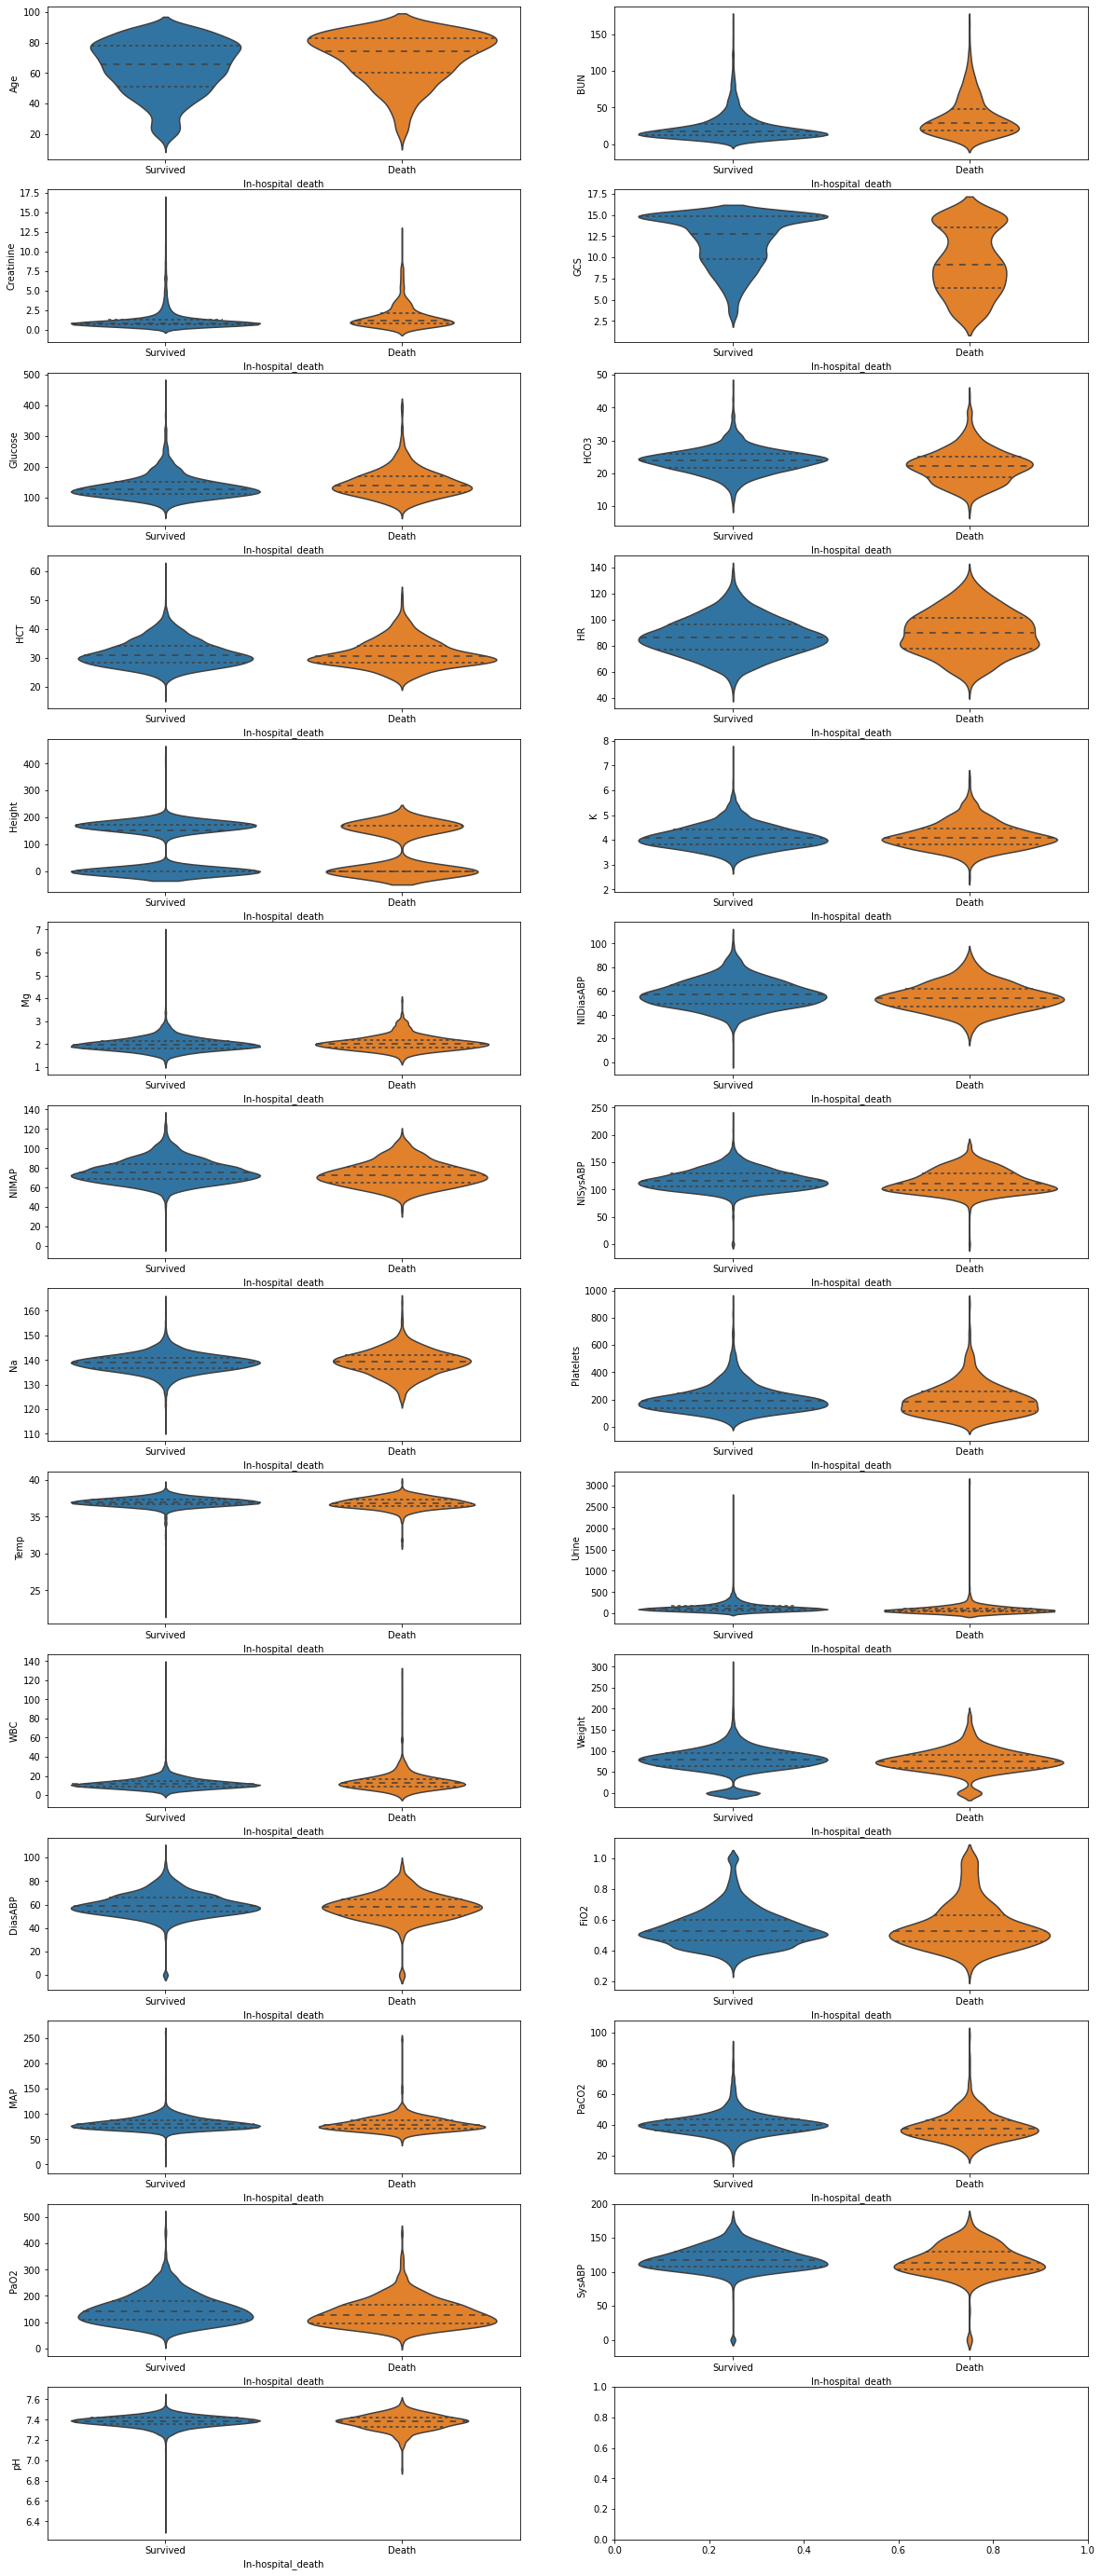

In [13]:
dataset_columns = df.drop(columns=['ICUType', 'Gender', 'MechVent','In-hospital_death']).columns
fig, axes = plt.subplots(14, 2, figsize=(20,50))
col_count = 0  
for i in range(14):
    for j in range(2):
        try: 
            g = sns.violinplot(data=df, x="In-hospital_death", y=dataset_columns[col_count],inner="quartile" , ax= axes[i,j])
            g.set_xticklabels(['Survived','Death'])
            col_count+=1
        except:
                pass
# Create violin plots for each feature VS label. The plots illutrate the distribution of 
# each feature for each category regarding the three quartiles (Q1, Q2, and Q3).

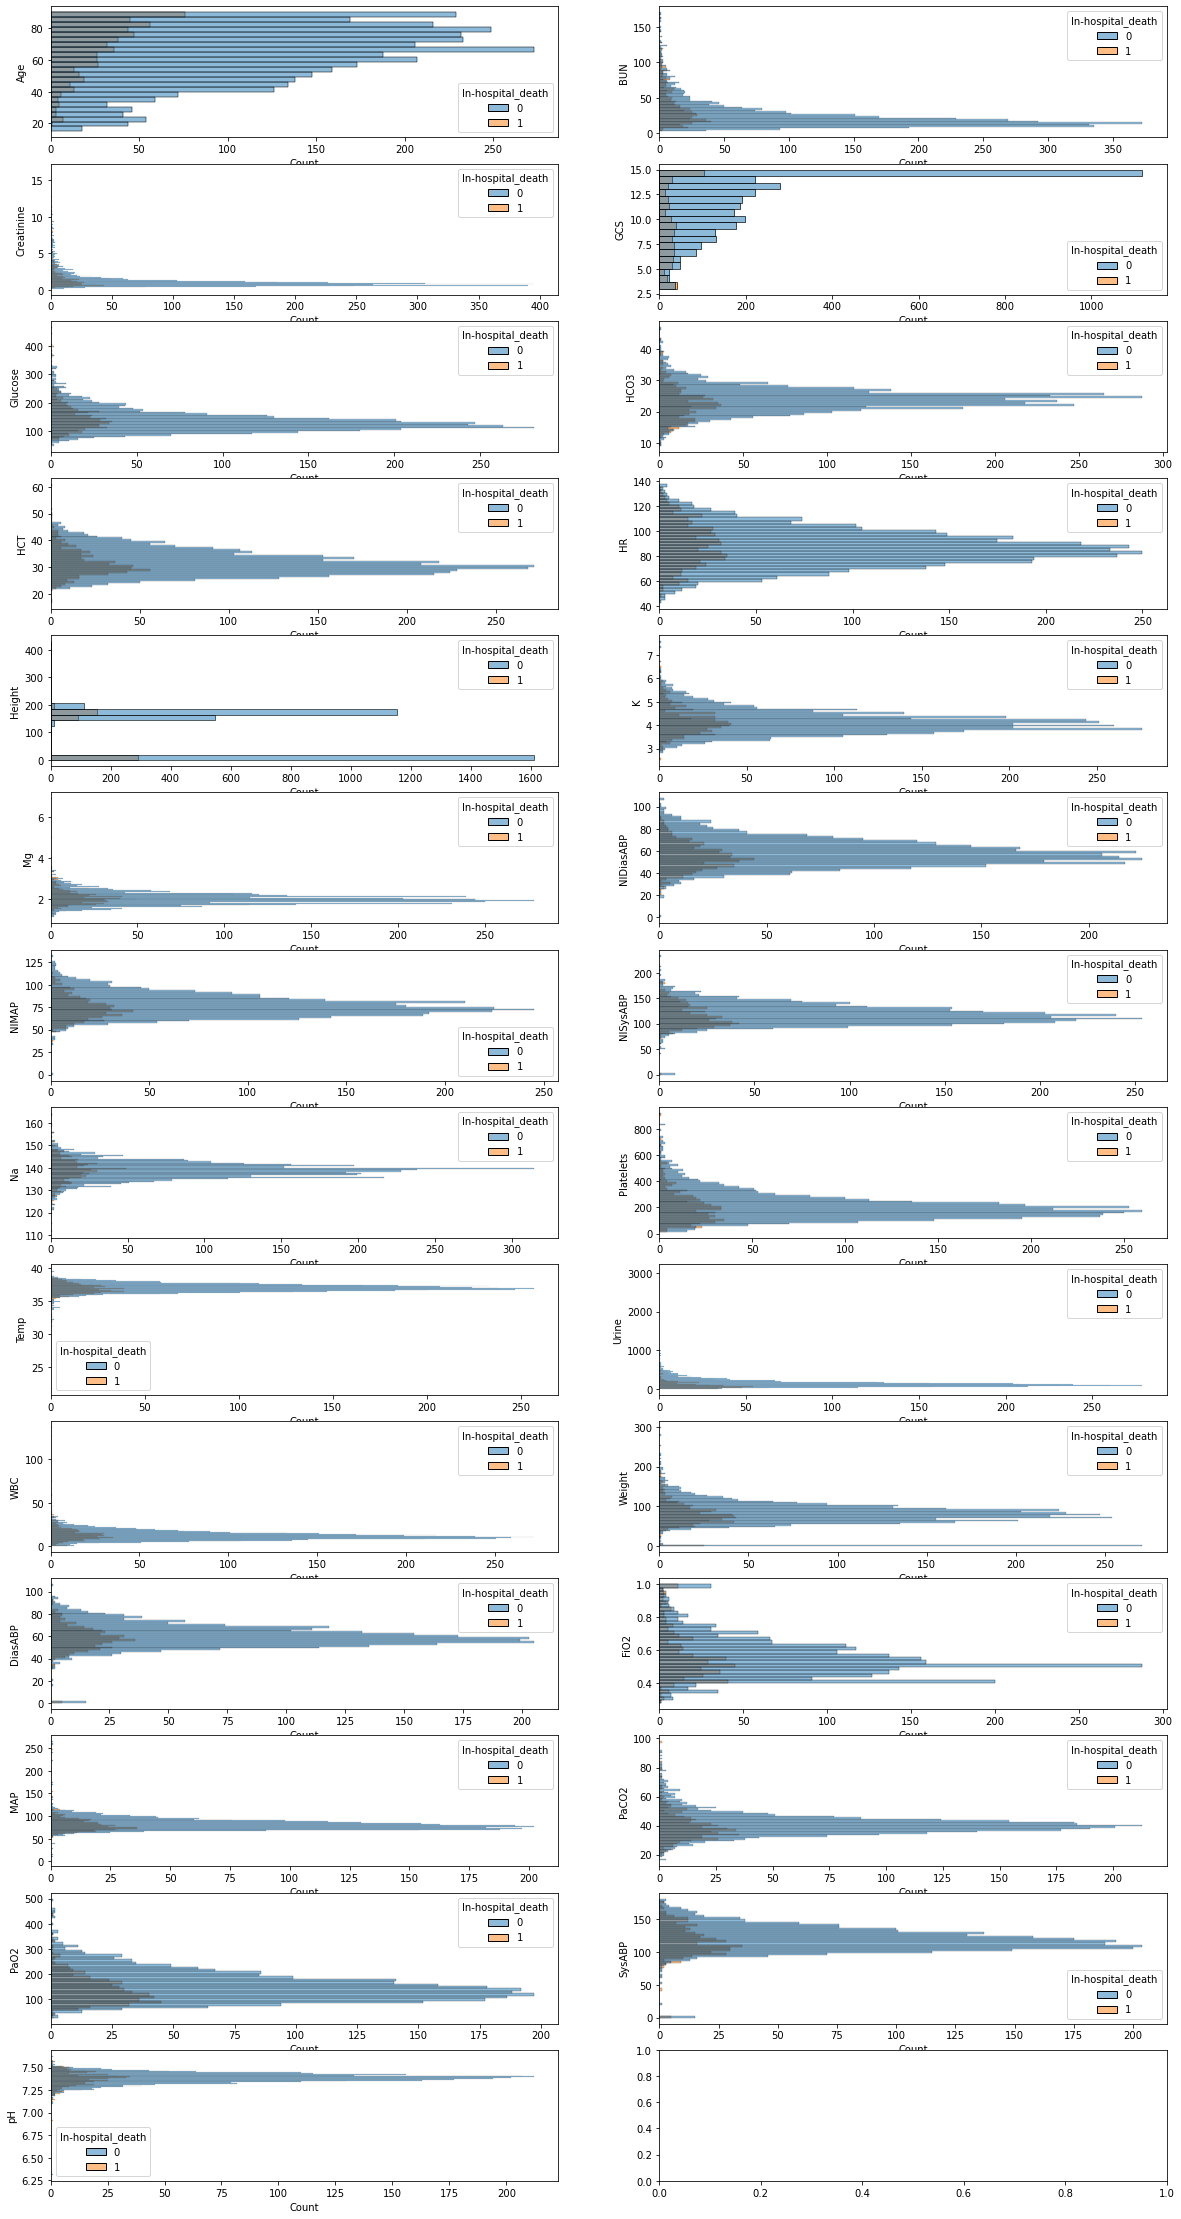

In [14]:
dataset_columns = df.drop(columns=['ICUType', 'Gender','MechVent', 'In-hospital_death']).columns
fig, axes = plt.subplots(14, 2, figsize=(20,40))
col_count = 0  
for i in range(14):
    for j in range(2):
           try: 
            sns.histplot(data=df, hue="In-hospital_death", y=dataset_columns[col_count],kde=False, ax= axes[i,j])
            col_count+=1
           except:
                pass
# Create violin plots for each feature VS label. The plots illutrate the distribution type of 
# each feature for each category.            

In [15]:
correlation_matrix = df.corr().sort_values('In-hospital_death', ascending=False)
# Find correlations between features

Wall time: 541 ms


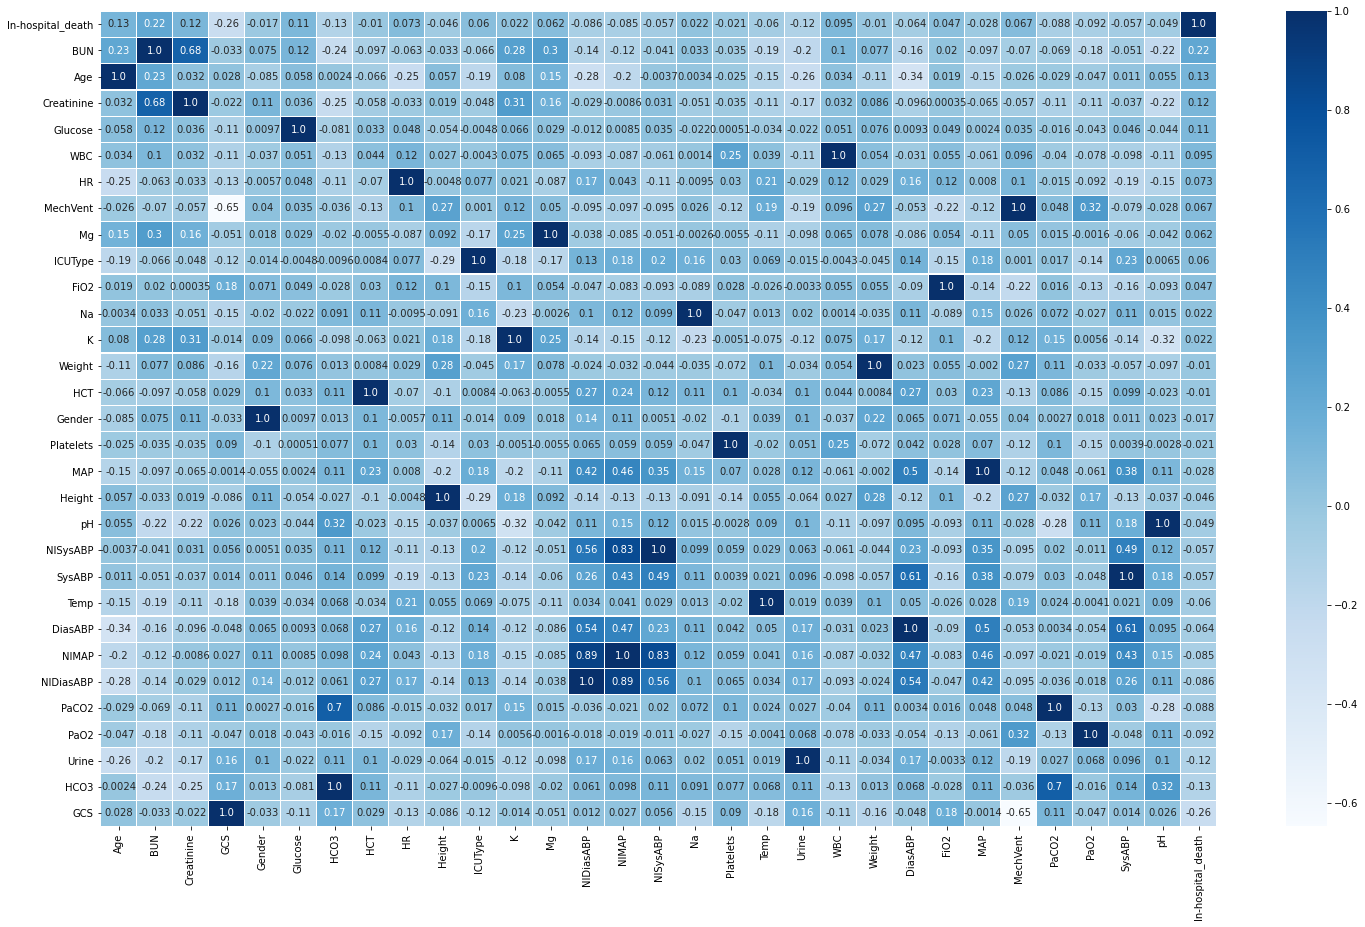

In [16]:
%%time
plt.figure(figsize=(25,15))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", linewidths=.15, fmt=".2");
# Presenting the correlation coefficients for feature-feature, we can see that the `BUN` and `GCS` are the most correlated with the target (In-hospital death)
# Note: the correlation matrix is sorted on the `In-hospital death` column, from most positively correlated to the most negatively.

## Data Investigation Results:

**Age:** The median ages (and ages at all) tend to be higher for the Death (eople who died in hospital) than the survived people

**Blood urea nitrogen (mg/dL) (BUN):** People died seem to have higher average BUN than survived people. 

**Serum creatinine (mg/dL):** Overall, death catigory has higher creatinine 

**Glasgow Coma Score (GCS):** The score is appearantly lower for people at "in hospital death" category.

**Serum glucose (mg/dL):** The Glucose levels seem to be slightly higher with the  "in hospital death" category.

**Heart rate (bpm):** The average heart rate is higher for "in hospital death" category.

**Serum bicarbonate (mmol/L):** The average HCO3 is slightly higher for "in hospital death" category.

**Hematocrit (%):** The average HCT levels are almost same for both categories.

**Hehight:** Almost same for both categories. The "Survived" category has some outliers.

**Serum potassium (mEq/L) (K):** Average potassium levels are same for both categories.

**Serum magnesium (mmol/L) (Mg):** Average magnesium levels are same for both categories.

**Invasive systolic arterial blood pressure (mmHg) (SysABP):** Average SysABP readings distributions are same for both categories, but the "in hospital death" category tends to have higher values

**Non-invasive diastolic arterial blood pressure (mmHg) (NIDiasABP):** Average NIDiasABP levels are same for both categories. 

**Non-invasive mean arterial blood pressure (mmHg) (NIMAP):** The average NIMAP distribution is almost same, but the survived category contains some people with clearly low levels.

**Serum sodium (mEq/L) (Na):** The average Na levels distribution is almost same, but the survived category contains some people with extreme low/high values .

**Platelets (cells/nL):** The average platelets levels distribution is same for both categories.

**Temperature (Celisius):** The average temperature readings distribution is same for both categories. However, the survived category has some outliers with extermly low values.

**Urine output (mL):** The average Urine levels are same for both categories. Also both have extreme values.

**White blood cell count (cells/nL):** The average WBC levels are same for both categories. Also both have extreme values.

**Weight (Kg):** The average weights distrubutions are same for both categories. However, the survived category has some outliers with extermly high values.

**Invasive diastolic arterial blood pressure (mmHg) (DiasABP):** Average DiasABP readings distribution are same for both categories.

**Fractional inspired O2 (0-1) (FiO2):** The "in hospital death" category has slightly higher average FiO2 readings.

**Invasive mean arterial blood pressure (mmHg) (MAP):** Average MAP levels are same for both categories.

**Partial pressure of arterial CO2 (mmHg) (PaCO2):** The average PaCO2 levels quartiles are almost same for both categories. Nevertheless, the "in hospital death" category tends to have higher values.\

**Partial pressure of arterial O2 (mmHg) (PaO2):**  The average PaCO2 levels distribution for "in hospital death" category seems to be lower than the "survived" category. 

**Arterial pH (0-14):** The average pH readings for the "in hospital death" category have higher frequency for the neutral pH (7). The "Survived" category has extremly lower values. 





# Data Preparation for Modeling 

- Imputing missing data 
- Dealing with the classes imbalance

In [17]:
copied_df = df.copy()

## Imputation

In [18]:
def impute(df,column, method):
    ''' The function works on imputing (filling nulls) in the specified column using the method entered
        
        Args:
            df: Pandas dataframe 
            column (String): The desired column name to impute
            method (String): The desired method to use for imputing ('mean', 'median', 'mode')
        
        Return:
            None  
    ''' 
    if method == 'median':
        print(f'{column}: imputed with median')
        death_group_statistic = df[df['In-hospital_death'] == 1][column].median()
        survived_group_statistic = df[df['In-hospital_death'] == 0][column].median()
    elif method == 'mean':
        death_group_statistic = df[df['In-hospital_death'] == 1][column].mean()
        survived_group_statistic = df[df['In-hospital_death'] == 0][column].mean()
        print(f'{column}: imputed with mean')    
    else:    
        death_group_statistic = df[df['In-hospital_death'] == 1][column].mode()[0]
        survived_group_statistic = df[df['In-hospital_death'] == 0][column].mode()[0]
        print(f'{column}: imputed with mode') 
        
    mask = (df['In-hospital_death'] == 1) & (df[column].isnull())
    df.loc[mask , column] = death_group_statistic
    # Imputing the `Death` group nulls for the specified column using the group's mean, median, or mode

    mask = (df['In-hospital_death'] == 0) & (df[column].isnull())
    df.loc[mask , column] = survived_group_statistic
    # Imputing the `Survived` group nulls for the specified column using the group's mean, median, or mode
    


In [19]:
# We should check each column's values statistics to decide which one to use for imputation (mean, median, mode)

In [20]:
copied_df.groupby('In-hospital_death').describe()['BUN']
# We should use the median as this feature has far values from the others (might be outliers also)

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3386.0,23.690184,19.157160,2.25,12.333333,18.000000,27.666667,170.833333
1,550.0,37.049081,25.776721,4.00,18.250000,29.071429,47.916667,163.666667


In [21]:
impute(copied_df, 'BUN', 'median') # Do Imputation

BUN: imputed with median


In [22]:
copied_df.groupby('In-hospital_death').describe()['GCS'] # We will use the mean for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3387.0,11.938966,3.021346,3.0,9.820856,12.75,14.846154,15.0
1,549.0,9.539243,3.839706,3.0,6.416667,9.16,13.547619,15.0


In [23]:
impute(copied_df, 'GCS', 'mean') # Do Imputation

GCS: imputed with mean


In [24]:
copied_df.groupby('In-hospital_death').describe()['Creatinine'] # We will use the mean for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3386.0,1.303263,1.374177,0.20,0.7,0.900,1.266667,16.457143
1,550.0,1.781973,1.597559,0.25,0.8,1.245,2.100000,12.140000


In [25]:
impute(copied_df, 'Creatinine', 'median') # Do Imputation

Creatinine: imputed with median


In [26]:
copied_df.groupby('In-hospital_death').describe()['Glucose'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3340.0,135.605452,39.424971,49.0,111.187500,128.0,150.425,467.333333
1,547.0,147.863623,45.169090,58.5,117.916667,139.5,170.900,396.000000


In [27]:
impute(copied_df, 'Glucose', 'median') # Do Imputation

Glucose: imputed with median


In [28]:
copied_df.groupby('In-hospital_death').describe()['HCO3'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3375.0,23.872040,3.831580,9.636364,21.50,24.000000,26.0,47.000000
1,549.0,22.310401,5.038537,9.125000,18.75,22.333333,25.0,43.333333


In [29]:
impute(copied_df, 'HCO3', 'median') # Do Imputation

HCO3: imputed with median


In [30]:
copied_df.groupby('In-hospital_death').describe()['HCT'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3386.0,31.456586,4.522134,16.600000,28.200000,30.688194,34.086932,61.05
1,550.0,31.321943,4.702342,21.466667,28.361667,30.358333,34.100000,51.85


In [31]:
impute(copied_df, 'HCT', 'median') # Do Imputation

HCT: imputed with median


In [32]:
copied_df.groupby('In-hospital_death').describe()['HR'] # We will use the mean for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3388.0,86.727948,14.207458,42.784314,76.939815,86.036752,96.013343,137.842105
1,549.0,89.823173,16.612770,48.672414,77.649123,89.744186,101.428571,133.245902


In [33]:
impute(copied_df, 'HR', 'mean') # Do Imputation

HR: imputed with mean


In [34]:
copied_df.groupby('In-hospital_death').describe()['K'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3357.0,4.130634,0.485587,2.825,3.8,4.066667,4.400000,7.6000
1,547.0,4.162198,0.538051,2.500,3.8,4.071429,4.466667,6.5125


In [35]:
impute(copied_df, 'K', 'median') # Do Imputation

K: imputed with median


In [36]:
copied_df.groupby('In-hospital_death').describe()['Mg'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3350.0,2.010533,0.305292,1.1,1.833333,1.975000,2.15,6.9
1,547.0,2.065453,0.322966,1.3,1.855000,2.016667,2.20,3.9


In [37]:
impute(copied_df, 'Mg', 'median') # Do Imputation

Mg: imputed with median


In [38]:
copied_df.groupby('In-hospital_death').describe()['NIDiasABP'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,2996.0,57.758976,11.692211,0.000000,49.520408,56.772222,64.977520,107.500000
1,487.0,54.844335,11.465890,20.807692,46.917092,53.800000,61.707143,91.294118


In [39]:
impute(copied_df, 'NIDiasABP', 'median') # Do Imputation

NIDiasABP: imputed with median


In [40]:
copied_df.groupby('In-hospital_death').describe()['NIMAP'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,2994.0,76.715318,12.013452,0.00,68.476064,75.108041,83.691897,132.540
1,487.0,73.749846,12.375236,37.25,65.204464,72.372093,81.238636,113.794


In [41]:
impute(copied_df, 'NIMAP', 'median') # Do Imputation

NIMAP: imputed with median


In [42]:
copied_df.groupby('In-hospital_death').describe()['NISysABP'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3005.0,117.725620,19.257231,0.0,105.000000,116.000000,129.140351,234.0
1,488.0,114.539834,20.686956,0.0,99.319767,111.298413,129.003788,181.0


In [43]:
impute(copied_df, 'NISysABP', 'median') # Do Imputation

NISysABP: imputed with median


In [44]:
copied_df.groupby('In-hospital_death').describe()['Na'] # We will use the mean for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3377.0,138.822443,3.897774,111.500000,136.50,139.000000,141.0,164.533333
1,548.0,139.085193,5.123249,123.555556,136.25,139.333333,142.0,163.428571


In [45]:
impute(copied_df, 'Na', 'mean') # Do Imputation

Na: imputed with mean


In [46]:
copied_df.groupby('In-hospital_death').describe()['Platelets'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3382.0,206.196250,101.032717,15.666667,139.175,188.666667,246.7875,925.666667
1,550.0,199.906255,116.197198,14.000000,114.175,185.000000,258.2500,898.000000


In [47]:
impute(copied_df, 'Platelets', 'median') # Do Imputation

Platelets: imputed with median


In [48]:
copied_df.groupby('In-hospital_death').describe()['Temp'] # We will use the mean for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3387.0,36.973785,0.717811,21.644615,36.642017,36.991379,37.373030,39.502941
1,549.0,36.847177,0.814340,31.090000,36.416216,36.845833,37.369231,39.748980


In [49]:
impute(copied_df, 'Temp', 'mean') # Do Imputation

Temp: imputed with mean


In [50]:
copied_df.groupby('In-hospital_death').describe()['Urine'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3346.0,139.867207,112.477951,0.0,79.767920,116.285431,168.300230,2746.250000
1,537.0,97.571650,148.439171,0.0,44.674419,72.325000,122.615385,3082.380952


In [51]:
impute(copied_df, 'Urine', 'median') # Do Imputation

Urine: imputed with median


In [52]:
copied_df.groupby('In-hospital_death').describe()['WBC'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,3377.0,12.290978,5.857981,0.1,8.833333,11.350000,14.775000,137.233333
1,550.0,14.070018,9.520487,0.1,9.037500,12.541667,17.091667,127.340000


In [53]:
impute(copied_df, 'WBC', 'median') # Do Imputation

WBC: imputed with median


In [54]:
copied_df.groupby('In-hospital_death').describe()['DiasABP'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,2390.0,59.827773,10.463396,0.0,53.840819,58.938331,65.908670,106.666667
1,409.0,57.881795,11.696148,0.0,51.184615,57.830189,64.392857,92.923077


In [55]:
impute(copied_df, 'DiasABP', 'median') # Do Imputation

DiasABP: imputed with median


In [56]:
copied_df.groupby('In-hospital_death').describe()['FiO2'] # We will use the mean for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,2273.0,0.546596,0.121189,0.280,0.466667,0.526667,0.600000,1.0
1,444.0,0.562526,0.149185,0.276,0.459844,0.528175,0.630769,1.0


In [57]:
impute(copied_df, 'FiO2', 'mean') # Do Imputation

FiO2: imputed with mean


In [58]:
copied_df.groupby('In-hospital_death').describe()['MAP'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,2386.0,81.216809,13.749042,2.000000,73.023657,79.227390,86.993750,265.0
1,406.0,80.104590,14.987964,46.882353,71.539718,77.513132,86.941346,247.0


In [59]:
impute(copied_df, 'MAP', 'median') # Do Imputation

MAP: imputed with median


In [60]:
copied_df.groupby('In-hospital_death').describe()['PaCO2'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,2549.0,40.676520,7.495669,16.000000,36.5000,40.0,43.555556,91.5
1,474.0,38.798296,8.950350,20.473684,33.2125,37.5,43.000000,98.0


In [61]:
impute(copied_df, 'PaCO2', 'median') # Do Imputation

PaCO2: imputed with median


In [62]:
copied_df.groupby('In-hospital_death').describe()['PaO2'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,2550.0,150.232254,57.118138,26.000,109.221429,140.864286,180.608333,500.0
1,473.0,135.883438,52.526422,26.625,96.055556,127.555556,166.000000,437.0


In [63]:
impute(copied_df, 'PaO2', 'median') # Do Imputation

PaO2: imputed with median


In [64]:
copied_df.groupby('In-hospital_death').describe()['SysABP'] # We will use the median for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,2390.0,119.056650,19.009434,0.0,107.906518,117.341641,129.757365,181.725000
1,409.0,115.871501,23.537171,0.0,103.018868,113.788732,130.298246,175.702128


In [65]:
impute(copied_df, 'SysABP', 'median') # Do Imputation

SysABP: imputed with median


In [66]:
copied_df.groupby('In-hospital_death').describe()['pH'] # We will use the mean for imputation

,count,mean,std,min,25%,50%,75%,max
In-hospital_death,,,,,,,,
0,2561.0,7.383450,0.056623,6.311667,7.355000,7.387222,7.417692,7.63000
1,472.0,7.375301,0.076730,6.912667,7.328991,7.383667,7.424071,7.57625


In [67]:
impute(copied_df, 'pH', 'mean') # Do Imputation

pH: imputed with mean


In [68]:
copied_df.info()
# Done: Imputation

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 132539 to 142673
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                4000 non-null   float64
 1   BUN                4000 non-null   float64
 2   Creatinine         4000 non-null   float64
 3   GCS                4000 non-null   float64
 4   Gender             4000 non-null   float64
 5   Glucose            4000 non-null   float64
 6   HCO3               4000 non-null   float64
 7   HCT                4000 non-null   float64
 8   HR                 4000 non-null   float64
 9   Height             4000 non-null   float64
 10  ICUType            4000 non-null   float64
 11  K                  4000 non-null   float64
 12  Mg                 4000 non-null   float64
 13  NIDiasABP          4000 non-null   float64
 14  NIMAP              4000 non-null   float64
 15  NISysABP           4000 non-null   float64
 16  Na               

In [69]:
# According to the dataset documentation, the values (-1) means `not recorded` so we will deal with it as Nans and perform imputation.
def impute_minusOne(df, column, method):
    ''' The function works on imputing (for records with values -1) in the specified column using the method entered
        
        Args:
            df: Pandas dataframe 
            column (String): The desired column name to impute
            method (String): The desired method to use for imputing ('mean', 'median', 'mode')
        
        Return:
            None  
    ''' 
    if method == 'median':
        print('Imputed With Median')
        death_group_statistic = df[(df['In-hospital_death'] == 1) & (df[column] != -1)][column].median()
        survived_group_statistic = df[(df['In-hospital_death'] == 0) & (df[column] != -1)][column].median()
    elif method == 'mean':
        death_group_statistic = df[(df['In-hospital_death'] == 1) & (df[column] != -1)][column].mean()
        survived_group_statistic = df[(df['In-hospital_death'] == 0) & (df[column] != -1)][column].mean()
        print('Imputed With Mean')    
    else:    
        death_group_statistic = df[(df['In-hospital_death'] == 1) & (df[column] != -1)][column].mode()[0]
        survived_group_statistic = df[(df['In-hospital_death'] == 0) & (df[column] != -1)][column].mode()[0]
        print('Imputed With Mode') 
        
    mask = (df['In-hospital_death'] == 1) & (df[column] == -1)
    df.loc[mask , column] = death_group_statistic
    # Imputing the `Death` group -1's for the specified column using the group's mean, median, or mode

    mask = (df['In-hospital_death'] == 0) & (df[column] == -1)
    df.loc[mask , column] = survived_group_statistic
    # Imputing the `Survived` group -1's for the specified column using the group's mean, median, or mode

In [70]:
impute_minusOne(copied_df, 'Weight', 'mean')
impute_minusOne(copied_df, 'Height', 'mean')
impute_minusOne(copied_df, 'Gender', 'mode')

Imputed With Mean
Imputed With Mean
Imputed With Mode


In [71]:
print(copied_df[(copied_df['Gender'] == -1)].any().any())
print(copied_df[(copied_df['Height'] == -1)].any().any())
print(copied_df[(copied_df['Weight'] == -1)].any().any())
# All Done Successfully

False
False
False


## Dealing With Classes Imbalance
As the dataset contains imbalanced classes, we added new records (2892) for the dataset. Each record contains the value for each feature estimated by using the random choice function as each value is chosen randomly from an array of the feature's unique values for the `death` group in the original dataset. The choosing process is done based on the probability of the value in the original dataset and for the `death` group (The value's frequency/death group records count).

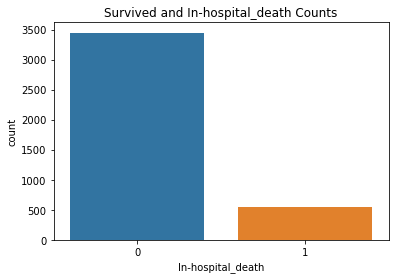

In [125]:
sns.countplot(data=copied_df, x='In-hospital_death');
plt.title('Survived and In-hospital_death Counts');

In [73]:
survived_count = copied_df[copied_df['In-hospital_death'] == 0].shape[0] # count of survived Category records
death_count = copied_df[copied_df['In-hospital_death'] == 1].shape[0] # count of death Category records

print(f'classes count difference: {survived_count - death_count}')

classes count difference: 2892


In [74]:
death_df = pd.DataFrame()  # Create empty dataframe  
for col in copied_df.columns:
    probs = (copied_df[copied_df['In-hospital_death'] == 1][col].value_counts()/death_count).sort_index().values # Get array of each value probability for the specified column
    vals = copied_df[copied_df['In-hospital_death'] == 1][col].unique() # Get array of the column's unique values
    vals = np.sort(vals) # Sort the values acsendingly
    dist = np.random.choice(vals, p=probs, size=survived_count-death_count) # Create array of values based on the value probability in the original dataset. The size will be the difference between the 2 classes size

    death_df[col] = dist # Set the values to the column in the new dataset

In [75]:
death_df.head()

,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,Height,...,Weight,DiasABP,FiO2,MAP,MechVent,PaCO2,PaO2,SysABP,pH,In-hospital_death
0,78.0,24.750000,1.300000,12.900000,0.0,136.333333,25.000000,33.75,85.451613,182.900000,...,67.300000,57.830189,0.518750,67.063830,1.0,45.785714,127.555556,117.109091,7.394000,1
1,57.0,38.000000,0.583333,15.000000,1.0,182.750000,23.000000,31.10,84.705882,168.682759,...,49.206667,49.076923,0.571429,98.044444,0.0,28.333333,127.555556,100.156863,7.391000,1
2,57.0,23.333333,0.860000,10.230769,0.0,84.400000,26.250000,34.45,83.568421,162.600000,...,100.000000,52.018519,0.442857,64.428571,1.0,44.800000,107.000000,113.788732,7.338571,1
3,78.0,13.200000,0.666667,3.214286,0.0,166.333333,17.833333,33.45,81.659574,166.400000,...,74.033333,69.288462,0.383333,77.513132,1.0,27.000000,143.500000,129.644444,7.345000,1
4,77.0,69.333333,0.650000,3.210526,0.0,143.000000,17.000000,35.30,93.827957,157.500000,...,72.000000,48.756757,0.462500,77.513132,0.0,37.500000,155.571429,113.788732,7.378571,1


In [76]:
(copied_df.columns == death_df.columns).sum()
# Check columns are identical

31

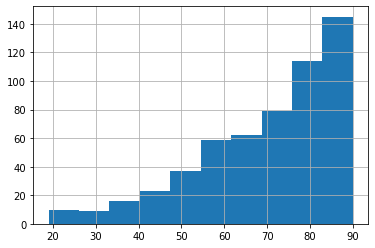

In [77]:
copied_df[copied_df['In-hospital_death'] == 1]['Age'].hist()

In [78]:
balanced_df = pd.concat([copied_df, death_df]) # Create the dataset contains same number of records for each class

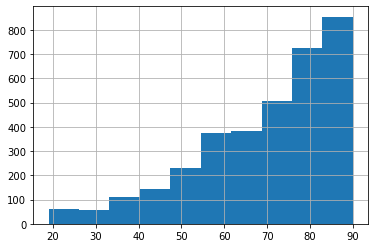

In [79]:
balanced_df[balanced_df['In-hospital_death'] == 1]['Age'].hist() # Almost same as the distribution Age in the original dataset (test example)

In [80]:
balanced_df[balanced_df['In-hospital_death'] == 1].shape[0] == balanced_df[balanced_df['In-hospital_death'] == 0].shape[0]
# Now classes are balanced

True

In [81]:
balanced_df.head()

,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,Height,...,Weight,DiasABP,FiO2,MAP,MechVent,PaCO2,PaO2,SysABP,pH,In-hospital_death
132539,54.0,10.500000,0.750000,14.923077,0.0,160.000000,27.000000,32.500000,70.810811,169.943469,...,83.591713,58.938331,0.546596,79.227390,0.0,40.000000,140.864286,117.341641,7.38345,0
132540,76.0,18.333333,1.100000,13.333333,1.0,125.500000,22.333333,28.655556,80.794118,175.300000,...,80.670588,58.897059,0.560000,76.940299,1.0,38.857143,210.142857,113.411765,7.39500,0
132541,44.0,4.666667,0.333333,5.923077,0.0,134.333333,25.000000,28.460000,83.759259,169.943469,...,56.700000,67.125000,0.500000,90.437500,1.0,35.500000,134.500000,125.687500,7.49500,0
132543,68.0,17.666667,0.766667,14.944444,1.0,117.333333,27.666667,37.442857,70.983333,180.300000,...,84.600000,58.938331,0.546596,79.227390,0.0,40.000000,140.864286,117.341641,7.38345,0
132545,88.0,35.000000,1.000000,15.000000,0.0,102.500000,19.000000,29.550000,74.958333,169.943469,...,83.591713,58.938331,0.546596,79.227390,0.0,40.000000,140.864286,117.341641,7.38345,0


In [82]:
scaler = StandardScaler().fit(balanced_df.drop(columns = 'In-hospital_death'))
scaled_data = scaler.transform(balanced_df.drop(columns = 'In-hospital_death'))
# Scaling data to zero mean and standard deviation equal to one. This step helps to improve the model training and accuracy

In [83]:
X = scaled_data
y = balanced_df['In-hospital_death']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create training and testing datasets 

In [84]:
print(f"Training Data Size: {X_train.shape[0]}")
print(f"Testing Data Size: {X_test.shape[0]}")

Training Data Size: 5513
Testing Data Size: 1379


In [85]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)
# Use the AUC (Area Under the Curve) as score metrics. 

# Modeling

In [86]:

DT_clf = DecisionTreeClassifier(max_depth = 7, min_samples_split = 300)
def build_model(model_type, cv=3, scorer=roc_auc_scorer):
    ''' Build a machine learning model to classifiy the patients
    
        Args:
            model_type ('RandomForest', 'KNeighbors', 'Adaboost', 'LogisticRegression'): Choose the model desired to build
            cv (int): The number of cross validations
            scorer (sklearn.metrics.make_scorer): scorer to use while building the model
            
        Return:
            model '''
    
    if model_type == 'RandomForest':
        rfc = RandomForestClassifier(random_state=0, n_jobs=-1)

        param_grid = { 
            'n_estimators': [100,250, 500],
            'max_depth' : [4,5,6,7,8],
            'min_samples_split' : [100,700], 
            'criterion' :['gini', 'entropy']
        }

        model = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= cv, scoring= scorer, verbose=1)
        model.fit(X_train, y_train)
        print('Best Model: ')
        print(model.best_estimator_)
        
    elif model_type == 'KNeighbors':
        knc = KNeighborsClassifier()

        param_grid = { 
            'n_neighbors': [3,7,10,15],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size' : [10,20,30,50],
            'weights' :['distance', 'uniform']
            }

        model = GridSearchCV(estimator=knc, param_grid=param_grid, cv= cv, scoring= scorer, verbose=1)
        model.fit(X_train, y_train)
        print('Best Model: ')
        model.best_estimator_
     
    elif model_type == 'Adaboost':
        Adaboost_clf = AdaBoostClassifier(random_state=0)

        param_grid = { 
            'n_estimators': [50,100,200,400],
            'learning_rate': [0.001, 0.1],
            'base_estimator': [DT_clf]
            }

        model = GridSearchCV(estimator=Adaboost_clf, param_grid=param_grid, cv= cv, scoring= scorer, verbose=1)
        model.fit(X_train, y_train)
        print('Best Model: ')
        model.best_estimator_
    
    elif model_type == 'LogisticRegression':
        LR_clf = LogisticRegression(random_state=0)

        param_grid = { 
            'penalty': ['none', 'elasticnet', 'l1', 'l2'],
            'C': [0.001, 0.1, 1, 5],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
            }

        model = GridSearchCV(estimator=LR_clf, param_grid=param_grid, cv= cv, scoring= scorer, verbose=1)
        model.fit(X_train, y_train)
        print('Best Model: ')
        model.best_estimator_
   
    # Save the model to file in the current working directory    
    pkl_filename = f"{model_type}_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)   
    
    return model

### RandomForest Classifier

In [87]:
%%time
RandomForests_model = build_model(model_type='RandomForest', cv=4)
# Build classification model using Random Forests algorithm 

Fitting 4 folds for each of 60 candidates, totalling 240 fits
Best Model: 
RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=100,
                       n_estimators=500, n_jobs=-1, random_state=0)
Wall time: 2min 33s


### KNeighbors Classifier

In [88]:
%%time
KNeighbors_model = build_model(model_type='KNeighbors', cv=4)
# Build classification model using KNeighbors algorithm 

Fitting 4 folds for each of 128 candidates, totalling 512 fits
Best Model: 
Wall time: 1min 45s


### AdaBoost Classifier

In [89]:
%%time
Adaboost_model = build_model(model_type='Adaboost', cv=4)
# Build classification model using Adaboost algorithm 

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best Model: 
Wall time: 4min 4s


### LogisticRegression Classifier

In [90]:
%%time
LogisticRegression_model = build_model(model_type='LogisticRegression', cv=4)
# Build classification model using Logistic Regression algorithm

Fitting 4 folds for each of 80 candidates, totalling 320 fits
Best Model: 
Wall time: 3.99 s


#### Define Model Testing Functions

In [91]:
def best_score_threshold(model):
    ''' Find the best probability threshold (that achieves the highest AUC) to consider the prediction as `In-hospital death`.
        Also plots the ROC curve.
        
        Args:
            model: The desired model.
            
        Return:
            best_score: the highest AUC score achieved by the model using different thresholds in the range (0-1).
            best_threshold: The threshold that yields the best score. '''
    
    model_pred_proba = model.predict_proba(X_test)
    fpr,tpr,thresholds = roc_curve(y_test,model_pred_proba[:,1])
    roc_auc_score(y_test, np.transpose(model_pred_proba[:,1]), average=None)

    best_threshold = 0
    best_score = 0
    for threshold in  np.arange(0,1.01,0.001):
        score = roc_auc_score(y_test, model_pred_proba[:,1] > threshold)
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    plt.plot(fpr, tpr)    
    plt.title('ROC Curve') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
  
    return best_score, best_threshold

In [92]:
def show_confusion_matrix(model, threshold):
    ''' Plot the confusion matrix that represents the model performance.
        
        Args:
            model: The desired model. 
            threshold: The threshold that yields the best score (resulted from `best_score_threshold` function).
        
        Return:
            None
 '''
    model_pred_proba = model.predict_proba(X_test)
    confusion_mat = confusion_matrix(y_test, model_pred_proba[:,1] > threshold)
    
    labels = ['True Neg','False Pos','False Neg','True Pos']
    make_confusion_matrix(confusion_mat, categories=['Survived','In-hospital_death'], cbar=False, figsize=(5,5), group_names=labels, percent=False)


###  RandomForest Classifier Performance Test

(0.937065652505167, 0.537)

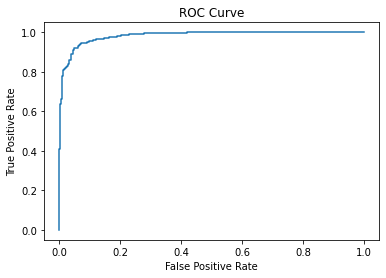

In [93]:
RandomForests_auc, RandomForests_threshold = best_score_threshold(model=RandomForests_model)

RandomForests_auc, RandomForests_threshold
#Find the best score and threshold for the Random Forests model

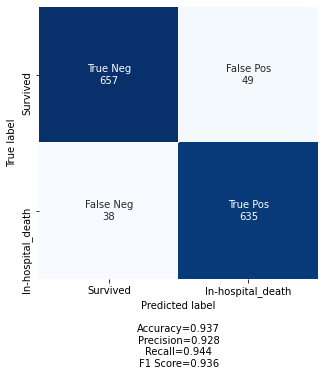

In [94]:
show_confusion_matrix(RandomForests_model, RandomForests_threshold)
# Plot confution matrix for the Random Forests model

### KNeighbors Classifier Performance Test

(0.8097805269206, 0.193)

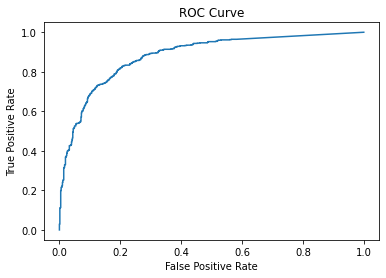

In [95]:
KNeighbors_auc, KNeighbors_threshold = best_score_threshold(model=KNeighbors_model)

KNeighbors_auc, KNeighbors_threshold
#Find the best score and threshold for the KNeighbors model

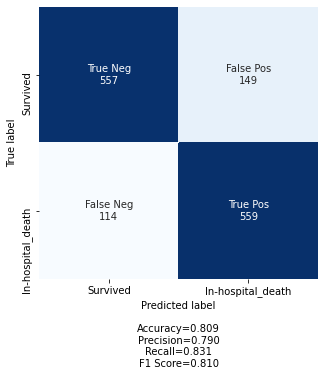

In [96]:
show_confusion_matrix(KNeighbors_model, KNeighbors_threshold)
# Plot confution matrix for the KNeighbors model

### Test Adaboost Classifier Performance

(0.9749136040476662, 0.51)

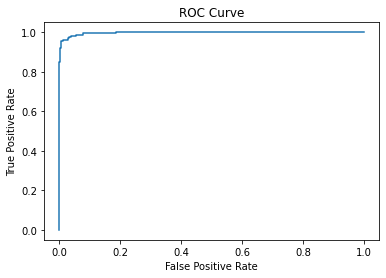

In [97]:
Adaboost_auc, Adaboost_threshold = best_score_threshold(model=Adaboost_model)

Adaboost_auc, Adaboost_threshold
#Find the best score and threshold for the Adaboost model

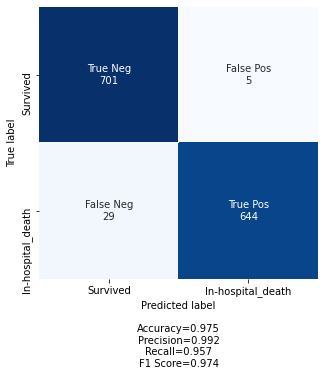

In [98]:
show_confusion_matrix(Adaboost_model, Adaboost_threshold)
# Plot confution matrix for the Adaboost model

### Logistic Regression Classifier Performance Test

(0.7505051164082857, 0.503)

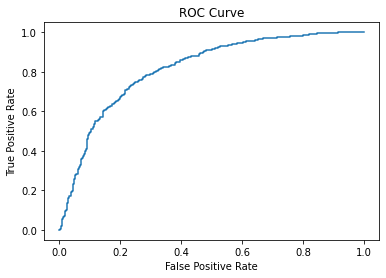

In [99]:
LogisticRegression_auc, LogisticRegression_threshold = best_score_threshold(model=LogisticRegression_model)

LogisticRegression_auc, LogisticRegression_threshold
#Find the best score and threshold for the Logistic Regression model

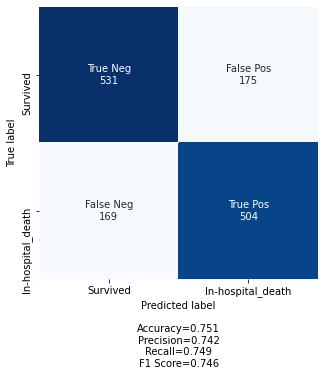

In [100]:
show_confusion_matrix(LogisticRegression_model, LogisticRegression_threshold)
# Plot confution matrix for the Logistic Regression model

### XGBoost Classifier

In [101]:
dtrain = xgb.DMatrix(X_train, label=y_train) # Prepare the training DMatrix 

param = {'max_depth': 3, 'eta': 0.1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
#Define the parameters for the model

In [102]:
%%time
num_round = 45
XGBoost_model = xgb.train(param, dtrain, num_round)
# Build the XGBoost model

Wall time: 219 ms


In [103]:
dtest  = xgb.DMatrix(X_test) # Prepare the testing DMatrix
xgb_pred_proba = XGBoost_model.predict(dtest)
# Find the probability for each record to be 'In-hospital_death'

In [104]:
best_threshold = 0
best_score = 0
for threshold in  np.arange(0,1.01,0.001):
    score = roc_auc_score(y_test, xgb_pred_proba > threshold)
    if score > best_score:
        best_score = score
        best_threshold = threshold
        
XGBoost_threshold =  best_threshold

best_score, XGBoost_threshold
#Find the best probability threshold (that achieves the highest AUC) to consider the prediction as `In-hospital death`. Also plots the ROC curve.

(0.9492442195741027, 0.483)

Text(0, 0.5, 'True Positive Rate')

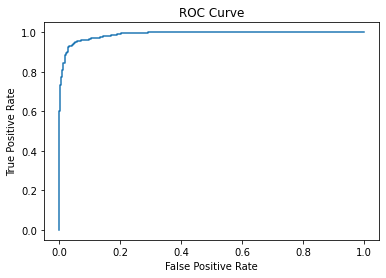

In [105]:
fpr,tpr,thresholds = roc_curve(y_test,xgb_pred_proba)
plt.plot(fpr, tpr)    
plt.title('ROC Curve') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Plot the ROC curve

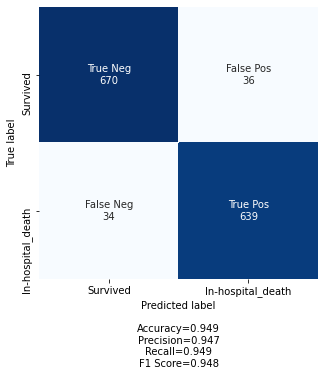

In [106]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_test, xgb_pred_proba > XGBoost_threshold)    
labels = ['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(confusion_mat, categories=['Survived','In-hospital_death'], cbar=False, figsize=(5,5), group_names=labels, percent=False)
# Plot confution matrix for the XGBoost model

## Set-B: In-hospital Death Prediction 

In [107]:
def ETL(num_range, features):
    '''The function extract the data for the new patients and apply the required transformation to be ready for model prediction
        
        Args:
            num_range: Range of the txt files numbers that desired to extracted and prepared for prediction
            features: The columns intended to be used for the prediction (must be as same as columns of the training data)
        Return:
            X: The processed-scaled data ready for applying model prediction
            y: Target column. It can be used for testing model accuracy'''
    test_df = pd.DataFrame()
    for file in tqdm(num_range):
        try: 
            read = pd.read_csv(f'set-b/{file}.txt').drop(columns='Time')
            read_pivot = read.pivot_table(values='Value' ,columns='Parameter', aggfunc='mean')
            test_df = pd.concat([test_df,read_pivot])
        except:
            pass     
    
    test_df['RecordID'] = test_df['RecordID'].astype('int')    
    targets = pd.read_csv('Outcomes-b.txt')
    test_df = pd.merge(test_df,targets[['RecordID','In-hospital_death']], on='RecordID')
    test_df = test_df.set_index('RecordID') 
    
    test_df.loc[test_df.pH>14, 'pH'] =  np.nan
    test_df = test_df.dropna(thresh=test_df.shape[0]*0.6,how='all',axis=1)
    test_df['MechVent'].fillna(0,inplace=True)

    method = {'BUN':'median', 'GCS':'mean', 'Glucose':'median', 'Creatinine':'median', 'HCO3':'median', 'HCT':'median', 'HR':'mean',
         'K':'median', 'Mg':'median', 'NIDiasABP':'median', 'NIMAP':'median', 'NISysABP':'median', 'Na':'mean', 'Platelets':'median',
         'Temp':'mean', 'Urine':'median', 'WBC':'median', 'DiasABP':'median', 'FiO2':'mean', 'MAP':'median', 'PaCO2':'median', 'PaO2':'median',
         'SysABP':'median', 'pH':'mean', 'Age':'median'}
    
    test_df = test_df[features]
    
    for col in test_df.columns:
        try:
            impute(test_df, col, method=method[col])
        except:
            pass
    try:    
        impute_minusOne(test_df, 'Weight', 'mean')
        impute_minusOne(test_df, 'Height', 'mean')
        impute_minusOne(test_df, 'Gender', 'mode')
    except:
        pass
    
    X = scaler.transform(test_df.drop(columns='In-hospital_death'))
    y = test_df['In-hospital_death']
    return X,y

In [108]:
def show_test_confusion_matrix(model, threshold, features, XGBoost=False):
    ''' Plot the confusion matrix that represents the model performance.
        
        Args:
            model: The desired model
            threshold: The threshold that yields the best score (resulted from `best_score_threshold` function)
            features: Number of features to be included when applying model prediction
            XGBoost: Choose whether the model is XGBoost classifier or not
        
        Return:
            None
    '''
    if XGBoost:
        dtest  = xgb.DMatrix(newPatients_X[:,:features])
        model_pred_proba = XGBoost_model.predict(dtest)
        confusion_mat = confusion_matrix(newPatients_y, model_pred_proba > threshold)

    else:
        model_pred_proba = model.predict_proba(newPatients_X[:,:features])
        confusion_mat = confusion_matrix(newPatients_y, model_pred_proba[:,1] > threshold)
    
    labels = ['True Neg','False Pos','False Neg','True Pos']
    make_confusion_matrix(confusion_mat, categories=['Survived','In-hospital_death'], cbar=False, figsize=(5,5), group_names=labels,
                          percent=False, cmap='Reds')


In [109]:
newPatients_X, newPatients_y = ETL(num_range=range(142675 , 152865), features=balanced_df.columns);
# Create the test data features and labels using ETL pipeline

100%|███████████████████████████████████████████████████████████████████████████| 10190/10190 [00:13<00:00, 728.73it/s]


Age: imputed with median
BUN: imputed with median
Creatinine: imputed with median
GCS: imputed with mean
Glucose: imputed with median
HCO3: imputed with median
HCT: imputed with median
HR: imputed with mean
K: imputed with median
Mg: imputed with median
NIDiasABP: imputed with median
NIMAP: imputed with median
NISysABP: imputed with median
Na: imputed with mean
Platelets: imputed with median
Temp: imputed with mean
Urine: imputed with median
WBC: imputed with median
DiasABP: imputed with median
FiO2: imputed with mean
MAP: imputed with median
PaCO2: imputed with median
PaO2: imputed with median
SysABP: imputed with median
pH: imputed with mean
Imputed With Mean
Imputed With Mean
Imputed With Mode


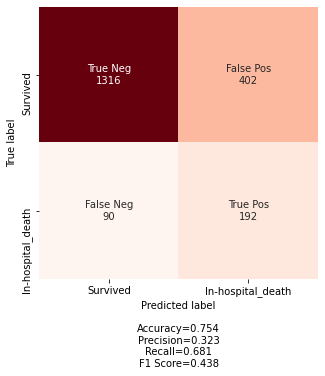

In [110]:
show_test_confusion_matrix(KNeighbors_model, KNeighbors_threshold, 30)
# Plot confution matrix for the KNeighbors model

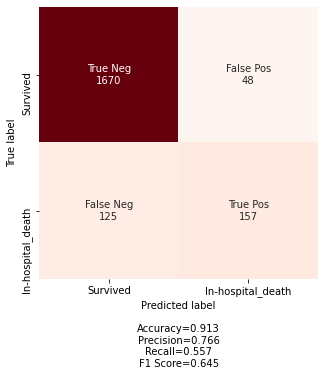

In [111]:
show_test_confusion_matrix(Adaboost_model, Adaboost_threshold, 30)
# Plot confution matrix for the Adaboost model

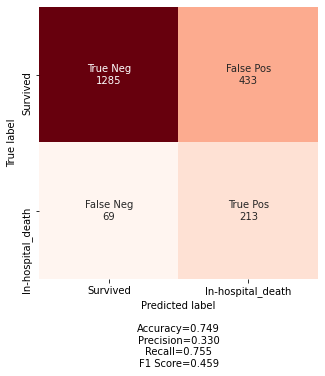

In [112]:
show_test_confusion_matrix(LogisticRegression_model, LogisticRegression_threshold, 30)
# Plot confution matrix for the Logistic Regression model

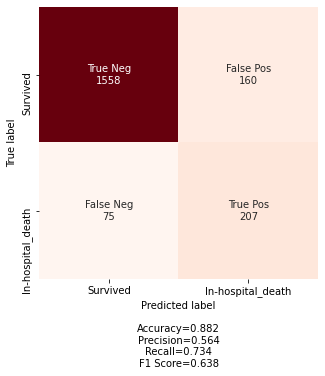

In [113]:
show_test_confusion_matrix(RandomForests_model, RandomForests_threshold, 30)
# Plot confution matrix for the Random Forests model

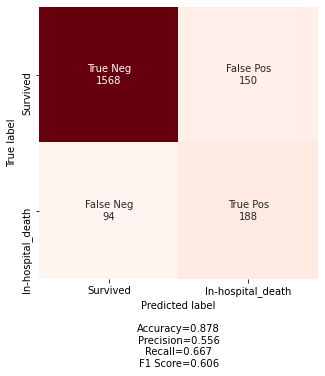

In [114]:
show_test_confusion_matrix(XGBoost_model, XGBoost_threshold, 30, XGBoost=True)
# Plot confution matrix for the XGBoost model

# Conclusion

> **By applying the data analysis techniques and visualization on set-A, we could infer that there are some observations correlated to in-hospital mortality. For instance, the Blood Urea Nitrogen (BUN) level is proportionally correlated with death/survival. Moreover, some features are dependent on each other like the Non-invasive diastolic arterial blood pressure (NIDiasABP) and the Non-invasive mean arterial blood pressure (NIMAP), Age, and Urine output.**

> **After exploration, we worked on building different Machine Learning models using the Sklearn library to predict the in-hospital mortality before the occurrence, based on the patients' observations collected at the ICU. However, the dataset had many obstacles that should be overcome.  For example, there were many columns with mostly null values. As a solution, we dropped all columns that have more than 40% nulls. the reason is to maintain the original distribution of each feature and avoid the undesired modification on the dataset information when applying imputation on the mostly-null features.**

> **By dealing with the missing data, the imbalanced classes was another problem. To retain the balance, we created a new distribution for each feature based on the original for the in-hospital death class data only. The new features had the same values' distribution as the original ones. Then we picked a value from each feature randomly and created a record.**

> **Next, we moved to the modeling step using different classification algorithms (Random Forests, Adaboost, k-nearest neighbor, Logistic regression, and XGBoost). The ROC curve (Area under the curve) is used as an evaluation metric, as we are interested in a low rate of false predictions. As a result, the threshold that achieves the highest AUC for each model was calculated. Consequently, we tested the models' performance and found that the XGBoost classifier has the best AUC.**

> **In the end, we created a simple ETL pipeline to extract and transform (process) the set-B data (testing data) to be ready for loading to apply the prediction algorithms. Accordingly, the Adaboost classifiers achieved the best accuracy and AUC. However, Logistic Regression model had the best recall where the Adaboost had the best precision.** 

> **Recommendation for Improvement: The data originally was collected in a time-series manner. By taking the observation's values average we might lose some information that leads to better performance. For more real applications, we recommend applying time-series analysis techniques to get more reliable models and decisions.** 